# Understanding Deep Q-Networks (DQN): A Complete Guide

# Table of Contents

- [Introduction](#introduction)
- [What is DQN?](#what-is-dqn)
  - [Why Deep Learning for Q-Learning?](#why-deep-learning)
- [Where and How DQN is Used](#where-and-how-dqn-is-used)
- [Mathematical Foundation of DQN](#mathematical-foundation-of-dqn)
  - [Q-Learning Recap](#q-learning-recap)
  - [Function Approximation](#function-approximation)
  - [The DQN Loss Function](#the-dqn-loss-function)
- [Step-by-Step Explanation of DQN](#step-by-step-explanation-of-dqn)
- [Key Components of DQN](#key-components-of-dqn)
  - [Q-Network](#q-network)
  - [Experience Replay](#experience-replay)
  - [Target Network](#target-network)
  - [Exploration vs. Exploitation](#exploration-vs-exploitation)
  - [Loss Function (MSE/Huber)](#loss-function-msehuber)
  - [Hyperparameters](#hyperparameters)
- [Practical Example: Custom Grid World](#practical-example-custom-grid-world)
- [Setting up the Environment](#setting-up-the-environment)
- [Creating the Custom Environment](#creating-the-custom-environment)
- [Implementing the DQN Algorithm](#implementing-the-dqn-algorithm)
  - [Defining the Q-Network](#defining-the-q-network)
  - [Defining the Replay Memory](#defining-the-replay-memory)
  - [Action Selection (Epsilon-Greedy)](#action-selection-epsilon-greedy)
  - [Optimization Step](#optimization-step)
  - [Target Network Update](#target-network-update)
- [Running the DQN Algorithm](#running-the-dqn-algorithm)
  - [Hyperparameter Setup](#hyperparameter-setup)
  - [Initialization](#initialization)
  - [Training Loop](#training-loop)
- [Visualizing the Learning Process](#visualizing-the-learning-process)
- [Analyzing the Learned Policy (Optional Visualization)](#analyzing-the-learned-policy-optional-visualization)
- [Common Challenges and Solutions in DQN](#common-challenges-and-solutions-in-dqn)
- [Conclusion](#conclusion)

## What is DQN?

Deep Q-Network (DQN) is a seminal algorithm in deep reinforcement learning that successfully combined Q-learning with deep neural networks to handle complex problems with high-dimensional state spaces. It demonstrated the power of using function approximation to learn value functions where traditional tabular methods fail due to the sheer size or continuous nature of the state space.

### Why Deep Learning for Q-Learning?

Tabular Q-learning maintains a table mapping every state-action pair to its estimated Q-value. This approach faces significant challenges:

1.  **Curse of Dimensionality:** As the number of state variables or their possible values increases, the size of the Q-table grows exponentially, quickly becoming computationally infeasible to store and update (e.g., game states represented by pixels, robotic sensor readings).
2.  **Continuous States:** Tabular methods cannot directly handle continuous state variables, requiring discretization, which can lose information and still suffer from dimensionality issues.

Deep neural networks overcome these limitations by acting as **function approximators**. Instead of storing a value for each specific state-action pair, a neural network $Q(s, a; \theta)$ learns a mapping from states (and possibly actions) to Q-values, parameterized by its weights $\theta$. This allows the network to generalize knowledge across similar states, making it suitable for large or continuous state spaces. Typically, the network takes the state $s$ as input and outputs estimated Q-values for all discrete actions possible in that state.

## Where and How DQN is Used

DQN marked a breakthrough, enabling RL solutions for previously intractable problems:

1.  **Video Game Playing:** Famously used to achieve superhuman performance on Atari 2600 games using raw pixel data as input.
2.  **Robotics:** Learning control policies from sensor data (though often adapted for continuous actions).
3.  **Optimization Problems:** Used in areas like resource allocation or system control where states are complex.
4.  **Sequential Decision Making:** Applicable in various domains like recommendation systems or dialogue management where states can be high-dimensional.

DQN is best suited for problems where:
- The state space is large, high-dimensional, or continuous.
- The action space is discrete.
- A model of the environment dynamics is not available (model-free).
- Learning can proceed off-policy (learning the optimal policy while potentially following a different exploration policy).

## Mathematical Foundation of DQN

### Q-Learning Recap

The foundation of DQN is the Q-learning update rule, which aims to iteratively improve the estimate of the action-value function $Q(s, a)$ – the expected total discounted future reward starting from state $s$, taking action $a$, and following the optimal policy thereafter. The Bellman optimality equation for $Q^*(s, a)$ is:

$$Q^*(s, a) = \mathbb{E}[R_{t+1} + \gamma \max_{a'} Q^*(S_{t+1}, a') | S_t=s, A_t=a]$$

The tabular Q-learning update rule approximates this iteratively:
$$Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ \underbrace{r_t + \gamma \max_{a'} Q(s_{t+1}, a')}_{\text{TD Target}} - Q(s_t, a_t) \right]$$

### Function Approximation

DQN replaces the Q-table with a neural network $Q(s, a; \theta)$. The network typically takes the state $s$ as input and outputs a vector of Q-values, $Q(s, \cdot; \theta)$, for all actions.

### The DQN Loss Function

Training the Q-network involves minimizing the difference between the predicted Q-value for the action taken, $Q(s_t, a_t; \theta)$, and a target value derived from the Bellman equation. A naive target would be $r_t + \gamma \max_{a'} Q(s_{t+1}, a'; \theta)$. However, using the same rapidly changing network for both prediction and target leads to instability. DQN introduces two crucial techniques:

1.  **Experience Replay:** Transitions $(s_t, a_t, r_t, s_{t+1}, \text{done}_t)$ experienced by the agent are stored in a replay buffer $\mathcal{D}$. Training involves sampling mini-batches of these transitions randomly from $\mathcal{D}$. This breaks the correlation between consecutive samples, making the training process more stable and data-efficient, resembling supervised learning.

2.  **Target Network:** A separate network $Q(s, a; \theta^-)$ with weights $\theta^-$ is used to compute the target Q-values. These weights are frozen for a period and only updated periodically (e.g., every $C$ steps) by copying the weights from the main Q-network ($\theta^- \leftarrow \theta$). This creates a more stable target for the main network to learn towards.

The target value $Y_t$ for a transition $(s_t, a_t, r_t, s_{t+1}, d_t)$ sampled from the replay buffer is:
$$ Y_t = \begin{cases} r_t & \text{if } d_t \text{ is True (terminal state)} \\ r_t + \gamma \max_{a'} Q(s_{t+1}, a'; \theta^-) & \text{if } d_t \text{ is False (non-terminal state)} \end{cases} $$

The loss function, typically Mean Squared Error (MSE) or Huber loss (Smooth L1), is minimized over the mini-batch using gradient descent:
$$ L(\theta) = \mathbb{E}_{(s, a, r, s', d) \sim \mathcal{D}} \left[ (Y_j - Q(s_j, a_j; \theta))^2 \right] $$

## Step-by-Step Explanation of DQN

1.  **Initialize**: Replay memory $\mathcal{D}$ (capacity $N$), main Q-network $Q(s, a; \theta)$ (random weights $\theta$), target network $Q(s, a; \theta^-)$ ($\theta^- = \theta$), exploration parameter $\epsilon$.
2.  **For each episode**:
    a.  Reset environment, get initial state $s_1$. Preprocess state if needed.
    b.  **For each step $t$**:
        i.  Select action $a_t$ using epsilon-greedy based on $Q(s_t, \cdot; \theta)$.
        ii. Execute $a_t$, observe reward $r_t$, next state $s_{t+1}$, done flag $d_t$. Preprocess $s_{t+1}$.
        iii. Store $(s_t, a_t, r_t, s_{t+1}, d_t)$ in $\mathcal{D}$.
        iv. **Sample mini-batch**: Get random batch from $\mathcal{D}$.
        v.  **Calculate targets $Y_j$** using the target network $Q(s, a; \theta^-)$.
        vi. **Train main network**: Perform gradient descent step on $L(\theta) = (Y_j - Q(s_j, a_j; \theta))^2$.
        vii. **Update target network**: Every $C$ steps, set $\theta^- \leftarrow \theta$.
        viii. $s_t \leftarrow s_{t+1}$.
        ix. If $d_t$, break episode.
3.  **Repeat**: Until convergence or max episodes.

## Key Components of DQN

### Q-Network
- The core function approximator. Learns to map states to action-values.
- Architecture depends on the state representation (MLP for vectors, CNN for images).
- Uses non-linear activation functions (like ReLU).
- Output layer typically has units equal to the number of discrete actions, outputting raw Q-values (no final activation).

### Experience Replay
- Stores agent's experiences.
- Breaks correlations and allows reusing data, improving stability and sample efficiency.
- Implemented using data structures like `deque`.

### Target Network
- A copy of the main Q-network, updated less frequently.
- Provides stable targets during the calculation of the TD error, preventing the 'moving target' problem.
- Crucial for stabilizing DQN training.

### Exploration vs. Exploitation
- Commonly uses epsilon-greedy: act randomly with probability $\epsilon$, greedily (based on Q-network) with probability $1-\epsilon$.
- Epsilon annealing: $\epsilon$ decreases over time (e.g., linearly or exponentially) from a high initial value to a low final value.

### Loss Function (MSE/Huber)
- Measures the difference between the network's prediction and the TD target.
- Huber loss (Smooth L1 Loss in PyTorch) is often preferred over MSE as it's less sensitive to outliers, which can occur with large TD errors early in training.

### Hyperparameters
- DQN performance is sensitive to hyperparameters like learning rate, buffer size, batch size, target update frequency, discount factor, and epsilon schedule. Careful tuning is often required.

## Practical Example: Custom Grid World

Since Gymnasium is disallowed, we'll create a simple, custom Grid World environment.

**Environment Description:**
- **Grid Size:** 10x10.
- **State:** Agent's `(row, col)` position. Represented as a normalized vector `[row/10, col/10]` for the network input.
- **Actions:** 4 discrete actions: 0 (up), 1 (down), 2 (left), 3 (right).
- **Start State:** (0, 0).
- **Goal State:** (9, 9).
- **Rewards:**
    - +10 for reaching the goal state (9, 9).
    - -1 for hitting a wall (attempting to move off-grid).
    - -0.1 for any other step (small cost to encourage efficiency).
- **Termination:** Episode ends when the agent reaches the goal or after a maximum number of steps.

# Setting up the Environment

We need to import the required libraries and set up the environment. So let's do that first.

In [1]:
# Import necessary libraries for numerical computations, plotting, and utility functions
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from collections import namedtuple, deque
from itertools import count
from typing import List, Tuple, Dict, Optional

# Import PyTorch for building and training neural networks
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Set up the device to use GPU if available, otherwise fallback to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set a random seed for reproducibility across runs
seed = 42
random.seed(seed)  # Seed for Python's random module
np.random.seed(seed)  # Seed for NumPy
torch.manual_seed(seed)  # Seed for PyTorch (CPU)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)  # Seed for PyTorch (GPU)

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


Using device: cpu


# Creating the Custom Environment

The very first step is to create a custom environment that simulates a simple grid world. This environment will have a grid of size 10x10, where the agent can move in four directions: up, down, left, and right. The agent starts at the top-left corner (0, 0) and aims to reach the bottom-right corner (9, 9). The agent receives rewards based on its actions and the state it reaches. The rewards are defined as follows:
- +10 for reaching the goal (bottom-right corner)
- -1 for hitting a wall (out of bounds)
- -0.1 for each step taken (to encourage shorter paths)

In [9]:
# Custom Grid World Environment
class GridEnvironment:
    """
    A simple 10x10 Grid World environment.
    State: (row, col) represented as normalized vector [row/10, col/10].
    Actions: 0 (up), 1 (down), 2 (left), 3 (right).
    Rewards: +10 for reaching the goal, -1 for hitting a wall, -0.1 for each step.
    """

    def __init__(self, rows: int = 10, cols: int = 10) -> None:
        """
        Initializes the Grid World environment.

        Parameters:
        - rows (int): Number of rows in the grid.
        - cols (int): Number of columns in the grid.
        """
        self.rows: int = rows
        self.cols: int = cols
        self.start_state: Tuple[int, int] = (0, 0)  # Starting position
        self.goal_state: Tuple[int, int] = (rows - 1, cols - 1)  # Goal position
        self.state: Tuple[int, int] = self.start_state  # Current state
        self.state_dim: int = 2  # State represented by 2 coordinates (row, col)
        self.action_dim: int = 4  # 4 discrete actions: up, down, left, right

        # Action mapping: maps action index to (row_delta, col_delta)
        self.action_map: Dict[int, Tuple[int, int]] = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, -1),  # Left
            3: (0, 1)    # Right
        }

    def reset(self) -> torch.Tensor:
        """
        Resets the environment to the start state.

        Returns:
            torch.Tensor: The initial state as a normalized tensor.
        """
        self.state = self.start_state
        return self._get_state_tensor(self.state)

    def _get_state_tensor(self, state_tuple: Tuple[int, int]) -> torch.Tensor:
        """
        Converts a (row, col) tuple to a normalized tensor for the network.

        Parameters:
        - state_tuple (Tuple[int, int]): The state represented as a tuple (row, col).

        Returns:
            torch.Tensor: The normalized state as a tensor.
        """
        # Normalize coordinates to be between 0 and 1
        normalized_state: List[float] = [
            state_tuple[0] / (self.rows - 1),
            state_tuple[1] / (self.cols - 1)
        ]
        return torch.tensor(normalized_state, dtype=torch.float32, device=device)

    def step(self, action: int) -> Tuple[torch.Tensor, float, bool]:
        """
        Performs one step in the environment based on the given action.

        Args:
            action (int): The action to take (0: up, 1: down, 2: left, 3: right).

        Returns:
            Tuple[torch.Tensor, float, bool]: 
                - next_state_tensor (torch.Tensor): The next state as a normalized tensor.
                - reward (float): The reward for the action.
                - done (bool): Whether the episode has ended.
        """
        # If the goal state is already reached, return the current state
        if self.state == self.goal_state:
            return self._get_state_tensor(self.state), 0.0, True

        # Get the row and column deltas for the action
        dr, dc = self.action_map[action]
        current_row, current_col = self.state
        next_row, next_col = current_row + dr, current_col + dc

        # Default step cost
        reward: float = -0.1
        hit_wall: bool = False

        # Check if the action leads to hitting a wall (out of bounds)
        if not (0 <= next_row < self.rows and 0 <= next_col < self.cols):
            # Stay in the same state and incur a penalty
            next_row, next_col = current_row, current_col
            reward = -1.0
            hit_wall = True

        # Update the state
        self.state = (next_row, next_col)
        next_state_tensor: torch.Tensor = self._get_state_tensor(self.state)

        # Check if the goal state is reached
        done: bool = (self.state == self.goal_state)
        if done:
            reward = 10.0  # Reward for reaching the goal

        return next_state_tensor, reward, done

    def get_action_space_size(self) -> int:
        """
        Returns the size of the action space.

        Returns:
            int: The number of possible actions (4).
        """
        return self.action_dim

    def get_state_dimension(self) -> int:
        """
        Returns the dimension of the state representation.

        Returns:
            int: The number of dimensions in the state (2).
        """
        return self.state_dim

Okay, now that we have implemented our custom grid environment, let's instantiate it and verify its properties and functionality.

In [10]:
# Instantiate the custom grid environment with a 10x10 grid
custom_env = GridEnvironment(rows=10, cols=10)

# Get the size of the action space and state dimension
n_actions_custom = custom_env.get_action_space_size()
n_observations_custom = custom_env.get_state_dimension()

# Print basic information about the environment
print(f"Custom Grid Environment:")
print(f"Size: {custom_env.rows}x{custom_env.cols}")  # Grid size
print(f"State Dim: {n_observations_custom}")  # State dimension (2 for row and column)
print(f"Action Dim: {n_actions_custom}")  # Number of possible actions (4)
print(f"Start State: {custom_env.start_state}")  # Starting position
print(f"Goal State: {custom_env.goal_state}")  # Goal position

# Reset the environment and print the normalized state tensor for the start state
print(f"Example state tensor for (0,0): {custom_env.reset()}")

# Take an example step: move 'right' (action=3) and print the result
next_s, r, d = custom_env.step(3)  # Action 3 corresponds to moving right
print(f"Step result (action=right): next_state={next_s.cpu().numpy()}, reward={r}, done={d}")

# Take another example step: move 'up' (action=0) and print the result
# This should hit a wall since the agent is at the top row
next_s, r, d = custom_env.step(0)  # Action 0 corresponds to moving up
print(f"Step result (action=up): next_state={next_s.cpu().numpy()}, reward={r}, done={d}")

Custom Grid Environment:
Size: 10x10
State Dim: 2
Action Dim: 4
Start State: (0, 0)
Goal State: (9, 9)
Example state tensor for (0,0): tensor([0., 0.])
Step result (action=right): next_state=[0.         0.11111111], reward=-0.1, done=False
Step result (action=up): next_state=[0.         0.11111111], reward=-1.0, done=False


You can see that the agent is at the top row and moving up results in hitting a wall, which incurs a penalty of -1.0. The next state remains the same as the current state.

# Implementing the DQN Algorithm

Now, let's implement the core components: the Q-Network, the Replay Memory, the action selection policy, the optimization step, and the target network update mechanism.

### Defining the Q-Network

We define a simple Multi-Layer Perceptron (MLP) using PyTorch's `nn.Module`.

In [11]:
# Define the Q-Network architecture
class DQN(nn.Module):
    """ Simple MLP Q-Network """
    def __init__(self, n_observations: int, n_actions: int):
        """
        Initialize the DQN.

        Parameters:
        - n_observations (int): Dimension of the state space.
        - n_actions (int): Number of possible actions.
        """
        super(DQN, self).__init__()
        # Define network layers
        # Simple MLP: Input -> Hidden1 -> ReLU -> Hidden2 -> ReLU -> Output
        self.layer1 = nn.Linear(n_observations, 128) # Input layer
        self.layer2 = nn.Linear(128, 128)           # Hidden layer
        self.layer3 = nn.Linear(128, n_actions)      # Output layer (Q-values for each action)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Parameters:
        - x (torch.Tensor): Input tensor representing the state(s).

        Returns:
        - torch.Tensor: Output tensor representing Q-values for each action.
        """
        # Ensure input is float tensor
        if not isinstance(x, torch.Tensor):
             x = torch.tensor(x, dtype=torch.float32, device=device)
        elif x.dtype != torch.float32:
             x = x.to(dtype=torch.float32)

        # Apply layers with ReLU activation
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x) # Output layer has no activation (raw Q-values)

### Defining the Replay Memory

We use `collections.deque` for efficient storage and `random.sample` for batch sampling. A `namedtuple` helps organize the transition data.

In [13]:
# Define the structure for storing transitions
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward', 'done'))

# Define the Replay Memory class
class ReplayMemory(object):
    """ Stores transitions and allows sampling batches. """
    def __init__(self, capacity: int):
        """
        Initialize the Replay Memory.

        Parameters:
        - capacity (int): Maximum number of transitions to store.
        """
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """
        Save a transition.

        Parameters:
        - *args: The transition elements (state, action, next_state, reward, done).
        """
        self.memory.append(Transition(*args))

    def sample(self, batch_size: int) -> List[Transition]:
        """
        Sample a random batch of transitions from memory.

        Parameters:
        - batch_size (int): The number of transitions to sample.

        Returns:
        - List[Transition]: A list containing the sampled transitions.
        """
        return random.sample(self.memory, batch_size)

    def __len__(self) -> int:
        """ Return the current size of the memory. """
        return len(self.memory)

### Action Selection (Epsilon-Greedy)

This function selects an action based on the current state and Q-network, using the epsilon-greedy strategy for exploration.

In [14]:
# Action Selection (Epsilon-Greedy - Modified for single state tensor input)
def select_action_custom(state: torch.Tensor,
                         policy_net: nn.Module,
                         epsilon_start: float,
                         epsilon_end: float,
                         epsilon_decay: int,
                         n_actions: int) -> Tuple[torch.Tensor, float]:
    """
    Selects an action using the epsilon-greedy strategy for a single state tensor.

    Parameters:
    - state (torch.Tensor): The current state as a tensor of shape [state_dim].
    - policy_net (nn.Module): The Q-network used to estimate Q-values.
    - epsilon_start (float): Initial value of epsilon (exploration rate).
    - epsilon_end (float): Final value of epsilon after decay.
    - epsilon_decay (int): Decay rate for epsilon (higher value means slower decay).
    - n_actions (int): Number of possible actions.

    Returns:
    - Tuple[torch.Tensor, float]: 
        - The selected action as a tensor of shape [1, 1].
        - The current epsilon value after decay.
    """
    global steps_done_custom  # Counter to track the number of steps taken
    sample = random.random()  # Generate a random number for epsilon-greedy decision
    # Compute the current epsilon value based on the decay formula
    epsilon_threshold = epsilon_end + (epsilon_start - epsilon_end) * \
        math.exp(-1. * steps_done_custom / epsilon_decay)
    steps_done_custom += 1  # Increment the step counter

    if sample > epsilon_threshold:
        # Exploitation: Choose the action with the highest Q-value
        with torch.no_grad():
            # Add a batch dimension to the state tensor to make it [1, state_dim]
            state_batch = state.unsqueeze(0)
            # Get the action with the maximum Q-value (output shape: [1, n_actions])
            action = policy_net(state_batch).max(1)[1].view(1, 1)  # Reshape to [1, 1]
    else:
        # Exploration: Choose a random action
        action = torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

    return action, epsilon_threshold

### Optimization Step and Selecting Action

The optimization step involves sampling a mini-batch from the replay memory, calculating the target Q-values using the target network, and updating the main Q-network using backpropagation. The action selection is done using the epsilon-greedy strategy.

In [15]:
def optimize_model(memory: ReplayMemory,
                   policy_net: nn.Module,
                   target_net: nn.Module,
                   optimizer: optim.Optimizer,
                   batch_size: int,
                   gamma: float,
                   criterion: nn.Module = nn.SmoothL1Loss()) -> Optional[float]:
    """
    Performs one step of optimization on the policy network.

    Parameters:
    - memory (ReplayMemory): The replay memory containing past transitions.
    - policy_net (nn.Module): The main Q-network being optimized.
    - target_net (nn.Module): The target Q-network used for stable target computation.
    - optimizer (optim.Optimizer): The optimizer for updating the policy network.
    - batch_size (int): The number of transitions to sample for each optimization step.
    - gamma (float): The discount factor for future rewards.
    - criterion (nn.Module): The loss function to use (default: SmoothL1Loss).

    Returns:
    - Optional[float]: The loss value for the optimization step, or None if not enough samples.
    """
    # Ensure there are enough samples in memory to perform optimization
    if len(memory) < batch_size:
        return None

    # Sample a batch of transitions from replay memory
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))  # Unpack transitions into separate components

    # Identify non-final states (states that are not terminal)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                  device=device, dtype=torch.bool)

    # Stack non-final next states into a tensor
    if any(non_final_mask):  # Check if there are any non-final states
        non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    # Stack current states, actions, rewards, and dones into tensors
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    done_batch = torch.cat(batch.done)

    # Compute Q(s_t, a) for the actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for the next states using the target network
    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        if any(non_final_mask):  # Only compute for non-final states
            next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]

    # Compute the expected Q values using the Bellman equation
    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute the loss between predicted and expected Q values
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Perform backpropagation and optimization
    optimizer.zero_grad()  # Clear previous gradients
    loss.backward()  # Compute gradients
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)  # Clip gradients to prevent explosion
    optimizer.step()  # Update the policy network

    return loss.item()  # Return the loss value for logging

### Target Network Update

This function copies the weights from the main policy network to the target network. We'll use a "hard" update every `TARGET_UPDATE` steps.

In [16]:
def update_target_net(policy_net: nn.Module, target_net: nn.Module) -> None:
    """
    Copies the weights from the policy network to the target network.

    Parameters:
    - policy_net (nn.Module): The main Q-network whose weights are to be copied.
    - target_net (nn.Module): The target Q-network to which weights are copied.

    Returns:
    - None
    """
    target_net.load_state_dict(policy_net.state_dict())

# Running the DQN Algorithm

Set up the hyperparameters, initialize the networks, optimizer, and replay memory, then run the main training loop.

### Hyperparameter Setup

So we need to set up the environment and hyperparameters for the custom grid world. These parameters will define the learning rate, discount factor, batch size, and other important settings for the DQN algorithm.

In [17]:
# Hyperparameters for Custom Grid World
BATCH_SIZE_CUSTOM = 128
GAMMA_CUSTOM = 0.99         # Discount factor (encourage looking ahead)
EPS_START_CUSTOM = 1.0      # Start with full exploration
EPS_END_CUSTOM = 0.05       # End with 5% exploration
EPS_DECAY_CUSTOM = 10000    # Slower decay for potentially larger state space exploration needs
TAU_CUSTOM = 0.005          # Tau for soft updates (alternative, not used here)
LR_CUSTOM = 5e-4            # Learning rate (might need tuning)
MEMORY_CAPACITY_CUSTOM = 10000
TARGET_UPDATE_FREQ_CUSTOM = 20 # Update target net less frequently maybe
NUM_EPISODES_CUSTOM = 500      # More episodes might be needed
MAX_STEPS_PER_EPISODE_CUSTOM = 200 # Max steps per episode (grid size related)

### Initialization

So after defining the environment and the DQN, we can initialize the policy and target networks, optimizer, and replay memory. 

In [18]:
# Re-instantiate the custom GridEnvironment
custom_env: GridEnvironment = GridEnvironment(rows=10, cols=10)

# Get the size of the action space and state dimension
n_actions_custom: int = custom_env.get_action_space_size()  # Number of possible actions (4)
n_observations_custom: int = custom_env.get_state_dimension()  # Dimension of the state space (2)

# Initialize the policy network (main Q-network) and target network
policy_net_custom: DQN = DQN(n_observations_custom, n_actions_custom).to(device)  # Main Q-network
target_net_custom: DQN = DQN(n_observations_custom, n_actions_custom).to(device)  # Target Q-network

# Copy the weights from the policy network to the target network and set it to evaluation mode
target_net_custom.load_state_dict(policy_net_custom.state_dict())  # Synchronize weights
target_net_custom.eval()  # Set target network to evaluation mode

# Initialize the optimizer for the policy network
optimizer_custom: optim.AdamW = optim.AdamW(policy_net_custom.parameters(), lr=LR_CUSTOM, amsgrad=True)

# Initialize the replay memory with the specified capacity
memory_custom: ReplayMemory = ReplayMemory(MEMORY_CAPACITY_CUSTOM)

# Lists for plotting
episode_rewards_custom = []
episode_lengths_custom = []
episode_epsilons_custom = []
episode_losses_custom = []

### Training Loop

Now that we have coded everything, let's train the DQN agent on the custom grid world environment.

In [19]:
print("Starting DQN Training on Custom Grid World...")

# Initialize the global counter for epsilon decay
steps_done_custom = 0

# Training Loop
for i_episode in range(NUM_EPISODES_CUSTOM):
    # Reset the environment and get the initial state tensor
    state = custom_env.reset()
    total_reward = 0
    current_losses = []

    for t in range(MAX_STEPS_PER_EPISODE_CUSTOM):
        # Select an action using epsilon-greedy policy
        action_tensor, current_epsilon = select_action_custom(
            state, policy_net_custom, EPS_START_CUSTOM, EPS_END_CUSTOM, EPS_DECAY_CUSTOM, n_actions_custom
        )
        action = action_tensor.item()

        # Take a step in the environment
        next_state_tensor, reward, done = custom_env.step(action)
        total_reward += reward

        # Prepare tensors for storing in replay memory
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)
        action_tensor_mem = torch.tensor([[action]], device=device, dtype=torch.long)
        done_tensor = torch.tensor([done], device=device, dtype=torch.bool)

        # Store the transition in replay memory
        memory_next_state = next_state_tensor if not done else None
        memory_custom.push(state, action_tensor_mem, memory_next_state, reward_tensor, done_tensor)

        # Move to the next state
        state = next_state_tensor

        # Perform one optimization step on the policy network
        loss = optimize_model(
            memory_custom, policy_net_custom, target_net_custom, optimizer_custom, BATCH_SIZE_CUSTOM, GAMMA_CUSTOM
        )
        if loss is not None:
            current_losses.append(loss)

        # Break the loop if the episode is done
        if done:
            break

    # Store episode statistics
    episode_rewards_custom.append(total_reward)
    episode_lengths_custom.append(t + 1)
    episode_epsilons_custom.append(current_epsilon)
    episode_losses_custom.append(np.mean(current_losses) if current_losses else 0)

    # Update the target network periodically
    if i_episode % TARGET_UPDATE_FREQ_CUSTOM == 0:
        update_target_net(policy_net_custom, target_net_custom)

    # Print progress every 50 episodes
    if (i_episode + 1) % 50 == 0:
        avg_reward = np.mean(episode_rewards_custom[-50:])
        avg_length = np.mean(episode_lengths_custom[-50:])
        avg_loss = np.mean([l for l in episode_losses_custom[-50:] if l > 0])
        print(
            f"Episode {i_episode+1}/{NUM_EPISODES_CUSTOM} | "
            f"Avg Reward (last 50): {avg_reward:.2f} | "
            f"Avg Length: {avg_length:.2f} | "
            f"Avg Loss: {avg_loss:.4f} | "
            f"Epsilon: {current_epsilon:.3f}"
        )

print("Custom Grid World Training Finished.")

Starting DQN Training on Custom Grid World...
Episode 50/500 | Avg Reward (last 50): -10.29 | Avg Length: 100.86 | Avg Loss: 0.0349 | Epsilon: 0.624
Episode 100/500 | Avg Reward (last 50): 0.84 | Avg Length: 50.66 | Avg Loss: 0.0235 | Epsilon: 0.495
Episode 150/500 | Avg Reward (last 50): 1.94 | Avg Length: 50.42 | Avg Loss: 0.0251 | Epsilon: 0.396
Episode 200/500 | Avg Reward (last 50): 3.55 | Avg Length: 43.70 | Avg Loss: 0.0151 | Epsilon: 0.328
Episode 250/500 | Avg Reward (last 50): 6.31 | Avg Length: 29.42 | Avg Loss: 0.0140 | Epsilon: 0.290
Episode 300/500 | Avg Reward (last 50): 6.88 | Avg Length: 25.72 | Avg Loss: 0.0127 | Epsilon: 0.261
Episode 350/500 | Avg Reward (last 50): 6.20 | Avg Length: 27.26 | Avg Loss: 0.0123 | Epsilon: 0.234
Episode 400/500 | Avg Reward (last 50): 6.51 | Avg Length: 26.38 | Avg Loss: 0.0120 | Epsilon: 0.211
Episode 450/500 | Avg Reward (last 50): 6.89 | Avg Length: 24.20 | Avg Loss: 0.0060 | Epsilon: 0.193
Episode 500/500 | Avg Reward (last 50): 7.3

# Visualizing the Learning Process

Plot the results for the custom Grid World environment.

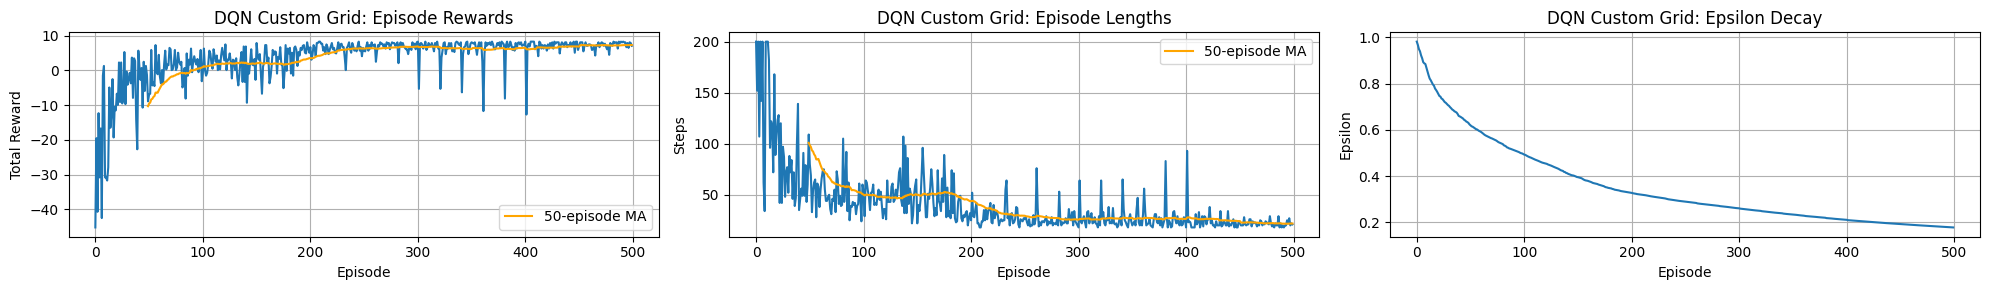

In [20]:
# Plotting results for Custom Grid World
plt.figure(figsize=(20, 3))

# Rewards
plt.subplot(1, 3, 1)
plt.plot(episode_rewards_custom)
plt.title('DQN Custom Grid: Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
rewards_ma_custom = np.convolve(episode_rewards_custom, np.ones(50)/50, mode='valid')
if len(rewards_ma_custom) > 0: # Avoid plotting empty MA
    plt.plot(np.arange(len(rewards_ma_custom)) + 49, rewards_ma_custom, label='50-episode MA', color='orange')
plt.legend()


# Lengths
plt.subplot(1, 3, 2)
plt.plot(episode_lengths_custom)
plt.title('DQN Custom Grid: Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.grid(True)
lengths_ma_custom = np.convolve(episode_lengths_custom, np.ones(50)/50, mode='valid')
if len(lengths_ma_custom) > 0:
    plt.plot(np.arange(len(lengths_ma_custom)) + 49, lengths_ma_custom, label='50-episode MA', color='orange')
plt.legend()

# Epsilon
plt.subplot(1, 3, 3)
plt.plot(episode_epsilons_custom)
plt.title('DQN Custom Grid: Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.grid(True)

plt.tight_layout()
plt.show()

**Analysis of DQN Learning Curves (Custom Grid World):**

1.  **Rewards Curve:** The rewards should generally increase over time, possibly with more fluctuations than CartPole due to the step cost and potential for getting stuck temporarily. The moving average should show a clear learning trend towards positive values as the agent more frequently reaches the goal (+10) while minimizing steps (-0.1 cost) and wall hits (-1).
2.  **Episode Length Curve:** Initially high, the episode lengths should decrease as the agent learns more direct paths to the goal. Plateaus or spikes might indicate periods where exploration leads to longer paths or getting trapped. Convergence towards the minimum possible steps from start to goal indicates good learning.
3.  **Epsilon Decay:** Shows the planned decrease in exploration probability over episodes.

This demonstrates DQN learning a policy in a custom, manually defined environment using only basic libraries alongside PyTorch for the neural network components.

# Analyzing the Learned Policy (Optional Visualization)

We can create a policy grid similar to the tabular methods, but now the policy is derived from the Q-network's output for each state.


Plotting Learned Policy from DQN:


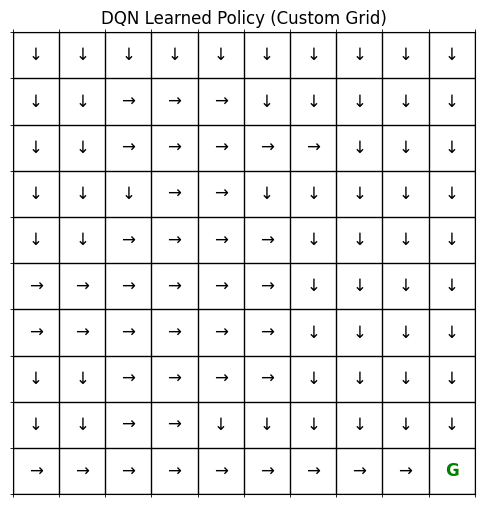

In [21]:
def plot_dqn_policy_grid(policy_net: nn.Module, env: GridEnvironment, device: torch.device) -> None:
    """
    Plots the greedy policy derived from the DQN for the given environment.

    Parameters:
    - policy_net (nn.Module): The trained Q-network used to derive the policy.
    - env (GridEnvironment): The custom grid environment.
    - device (torch.device): The device (CPU/GPU) on which the tensors are processed.

    Returns:
    - None: Displays the policy grid as a plot.
    """
    # Get the dimensions of the grid environment
    rows: int = env.rows
    cols: int = env.cols

    # Initialize an empty grid to store the policy symbols
    policy_grid: np.ndarray = np.empty((rows, cols), dtype=str)

    # Define symbols for each action
    action_symbols: Dict[int, str] = {0: '↑', 1: '↓', 2: '←', 3: '→'}

    # Create a figure for the plot
    fig, ax = plt.subplots(figsize=(cols * 0.6, rows * 0.6))  # Adjust size based on grid dimensions

    # Iterate over each cell in the grid
    for r in range(rows):
        for c in range(cols):
            state_tuple: Tuple[int, int] = (r, c)  # Current state as a tuple

            # If the current cell is the goal state, mark it with 'G'
            if state_tuple == env.goal_state:
                policy_grid[r, c] = 'G'
                ax.text(c, r, 'G', ha='center', va='center', color='green', fontsize=12, weight='bold')
            else:
                # Convert the state to a tensor representation
                state_tensor: torch.Tensor = env._get_state_tensor(state_tuple)

                # Use the policy network to determine the best action
                with torch.no_grad():
                    # Add a batch dimension to the state tensor
                    state_tensor = state_tensor.unsqueeze(0)
                    # Get Q-values for the current state
                    q_values: torch.Tensor = policy_net(state_tensor)
                    # Select the action with the highest Q-value
                    best_action: int = q_values.max(1)[1].item()

                # Store the action symbol in the policy grid
                policy_grid[r, c] = action_symbols[best_action]
                # Add the action symbol to the plot
                ax.text(c, r, policy_grid[r, c], ha='center', va='center', color='black', fontsize=12)

    # Set up the grid visualization
    ax.matshow(np.zeros((rows, cols)), cmap='Greys', alpha=0.1)  # Background grid
    ax.set_xticks(np.arange(-.5, cols, 1), minor=True)
    ax.set_yticks(np.arange(-.5, rows, 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)  # Minor grid lines
    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([])  # Remove y-axis ticks
    ax.set_title("DQN Learned Policy (Custom Grid)")  # Title of the plot

    # Display the plot
    plt.show()


# Plot the policy learned by the trained network
print("\nPlotting Learned Policy from DQN:")
plot_dqn_policy_grid(policy_net_custom, custom_env, device)

## Common Challenges and Solutions in DQN

**Challenge: Unstable Training / Divergence**
*   **Solutions**:
    *   **Tune Learning Rate:** Lower the learning rate (`LR`).
    *   **Increase Target Network Update Frequency:** Update the target network less often (increase `TARGET_UPDATE_FREQ`) or use soft updates (`TAU`).
    *   **Gradient Clipping:** Prevent exploding gradients.
    *   **Larger Replay Buffer:** Increase `MEMORY_CAPACITY`.
    *   **Different Optimizer/Loss:** Try RMSprop or Huber loss.

**Challenge: Slow Learning**
*   **Solutions**:
    *   **Tune Hyperparameters:** Increase learning rate cautiously, adjust epsilon decay, optimize batch size.
    *   **Network Architecture:** Experiment with different numbers of layers/neurons.
    *   **Prioritized Experience Replay:** Sample more "important" transitions from the buffer more often (more complex extension).
    *   **Double DQN / Dueling DQN:** Extensions that can improve performance and stability.

**Challenge: Overestimation of Q-values**
*   **Solution**: Implement **Double DQN**, which decouples action selection and value estimation in the target calculation.

**Challenge: Correlation in Replay Buffer**
*   **Solution**: Ensure sufficient buffer size and random sampling. Consider prioritized replay.

## Conclusion

The Deep Q-Network (DQN) algorithm successfully extends Q-learning to handle high-dimensional state spaces by using a deep neural network as a function approximator. Key innovations like Experience Replay and the use of a Target Network are crucial for stabilizing the learning process when combining deep learning with temporal difference methods.

As demonstrated with the CartPole environment, DQN can learn effective policies for tasks with continuous state spaces and discrete actions directly from experience. While basic DQN has limitations (e.g., overestimation, handling continuous actions), it forms the foundation for many advanced deep reinforcement learning algorithms like Double DQN, Dueling DQN, Rainbow, and Actor-Critic methods that address these challenges and tackle even more complex problems. Understanding DQN is a vital step in mastering modern reinforcement learning techniques.